<a href="https://colab.research.google.com/github/Lupo433/ECG-SAFE-OR-NOT-/blob/main/DL_FP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***QT Database - Classification***

## Uploading database

**Installing WFDB, TensorFlow and Keras Tuner**

The following command installs the `wfdb` Python library, which is required to read and process ECG signals from PhysioNet datasets such as the QT Database. This package provides tools for loading signals (`.dat`), metadata (`.hea`), and annotations (`.atr`).

In [ ]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 112.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


In [ ]:
pip install --upgrade tensorflow keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 116.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 131.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts

**Mounting Google Drive and Uploading datasets**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

qt_db_path = '/content/drive/MyDrive/DL_Project/qt-database-1.0.0/qt-database-1.0.0/'
files = os.listdir(qt_db_path)
print(files[:8])

['sele0606.hea', 'sel102.pu0', 'sel33.xws', 'sel31.man', 'sel213.pu1', 'sel16265.hea', 'sel233.dat', 'sel45.pu']


### QT Database Overview

The **QT Database (QTDB)** is a collection of 105 ECG recordings, each identified by a code of the form `selnnnn`, where `nnnn` corresponds to the original record number from the source databases.

Each recording contains **two ECG leads**:
- **MLII (Modified Lead II)**
- **V1 (precordial lead V1)**

Each signal has a duration of **approximately 15 minutes**, sampled at **250 Hz**, resulting in around **225,000 samples per signal**.

---

### Per-record Files (Up to 9 per patient)

For each recording, the dataset may include up to **9 files**, with the following suffixes:

| Suffix  | Description |
|---------|-------------|
| `.hea`  | **Header file** — describes format and content of the signal |
| `.dat`  | **Signal file** — binary data of the two ECG leads |
| `.atr`  | **Reference beat annotations** from original database (not always available) |
| `.man`  | **Manual annotations** of selected beats |
| `.q1c`  | **Waveform boundaries (2nd pass)** from annotator 1 |
| `.q2c`  | **Waveform boundaries (2nd pass)** from annotator 2 (only 11 records) |
| `.qt1`  | **Waveform boundaries (1st pass)** from annotator 1 |
| `.qt2`  | **Waveform boundaries (1st pass)** from annotator 2 (only 11 records) |
| `.pu`   | **Automatic waveform boundaries** from both leads |
| `.pu0`  | **Automatic waveform boundaries** from signal 0 (MLII) |
| `.pu1`  | **Automatic waveform boundaries** from signal 1 (V1) |

- Here a list of the most common libraries we used:

In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd


---
## Visualizations

### Visual Inspection of Full ECG Recordings

The plots below show the full-length ECG recording (≈15 minutes) for patient **sel853** from the QT Database.  
Both leads (**MLII** and **V1**) are displayed separately for clear comparison.

Use the interactive slider to:
-  Zoom into specific intervals
-  Navigate across the entire signal duration

This tool provides a direct visual exploration of beat morphology, rhythm, and signal quality in the original data.


In [ ]:
from ipywidgets import interactive, IntRangeSlider
from IPython.display import display

# Load ECG
record_id   = 'sel853' # Change this if you want to inspect another record
record_path = os.path.join(qt_db_path, record_id)

record = wfdb.rdrecord(record_path)
signal = record.p_signal
fs     = record.fs if hasattr(record, 'fs') else 250
duration_sec = signal.shape[0] // fs
t = np.arange(signal.shape[0]) / fs

# Function to visualize ECG in an interactive time range
def plot_ecg_window(time_range):
    start_sec, end_sec = time_range
    start_idx = int(start_sec * fs)
    end_idx = int(end_sec * fs)

    ti = t[start_idx:end_idx]
    sig0 = signal[start_idx:end_idx, 0]
    sig1 = signal[start_idx:end_idx, 1]

    plt.figure(figsize=(15, 6))

    plt.subplot(2, 1, 1)
    plt.plot(ti, sig0, color='blue')
    plt.title(f'{record_id} — MLII')
    plt.ylabel('Amplitude (mV)')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(ti, sig1, color='orange')
    plt.title(f'{record_id} — V1')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (mV)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Interactive time range slider
range_slider = IntRangeSlider(
    value=[0, 10],
    min=0,
    max=duration_sec,
    step=1,
    description='Interval (s)',
    continuous_update=False,
    layout={'width': '80%'}
)

interactive_plot = interactive(plot_ecg_window, time_range=range_slider)
display(interactive_plot)


interactive(children=(IntRangeSlider(value=(0, 10), continuous_update=False, description='Interval (s)', layou…

### Files Used for Classification

For our classification task, we rely on the following four core files from each record in the QT Database:

- **`.hea` (Header file)**: Contains metadata such as the number of signals, sampling frequency, signal names, and other configuration details.
- **`.dat` (Signal file)**: Stores the raw ECG signals in binary format, typically including two leads (MLII and V1).
- **`.atr` (Annotation file)**: Provides the R-peak positions (beat annotations) used as reference points to segment heartbeats.
- **`.pu0` and `.pu1` (Waveform boundary files)**: Contain automatically detected waveform boundaries for signals 0 and 1. We use them only to verify the correctness of the `.atr` beat annotations and ensure alignment with actual beat locations.

These files are sufficient for our purpose: heartbeat classification based on the raw ECG traces and annotated beat positions.

Now let’s see how the `.hea` file is structured and what it contains:


In [ ]:
# Configuration
record_id = 'sel853'
record_path = os.path.join(qt_db_path, record_id)

# Load header (.hea) information
record = wfdb.rdrecord(record_path)

print(f"\n Header Information for Record: {record_id}")
print("=" * 60)
print(f"Number of signals      : {record.n_sig}")
print(f"Sampling frequency     : {record.fs} Hz")
print(f"Duration               : {record.sig_len} samples ({record.sig_len / record.fs:.2f} seconds)")
print(f"Base date              : {record.base_date}")
print(f"Base time              : {record.base_time}")
print(f"Signal names           : {record.sig_name}")
print(f"Signal units           : {record.units}")
print(f"ADC gain per signal    : {record.adc_gain}")
print(f"Baseline values        : {record.baseline}")
print(f"Checksum values        : {record.checksum}")
print(f"Comments               : {record.comments}")
print("=" * 60)




 Header Information for Record: sel853
Number of signals      : 2
Sampling frequency     : 250 Hz
Duration               : 224999 samples (900.00 seconds)
Base date              : None
Base time              : None
Signal names           : ['ECG1', 'ECG2']
Signal units           : ['mV', 'mV']
ADC gain per signal    : [200.0, 200.0]
Baseline values        : [0, 0]
Checksum values        : [-17011, 1222]
Comments               : ['Produced by xform from record 853, beginning at 5:00.000']


### Visualizing ECG Signals with R-peak Annotations

In this step, we load a full ECG record from the QT Database and visualize both channels (MLII and V1) along with the `.atr` annotations. These annotations indicate R-peak positions, which are important reference points for detecting heartbeats.

The visualization helps verify the alignment between the raw signal and the annotated events, ensuring the integrity of the dataset before using it for classification.


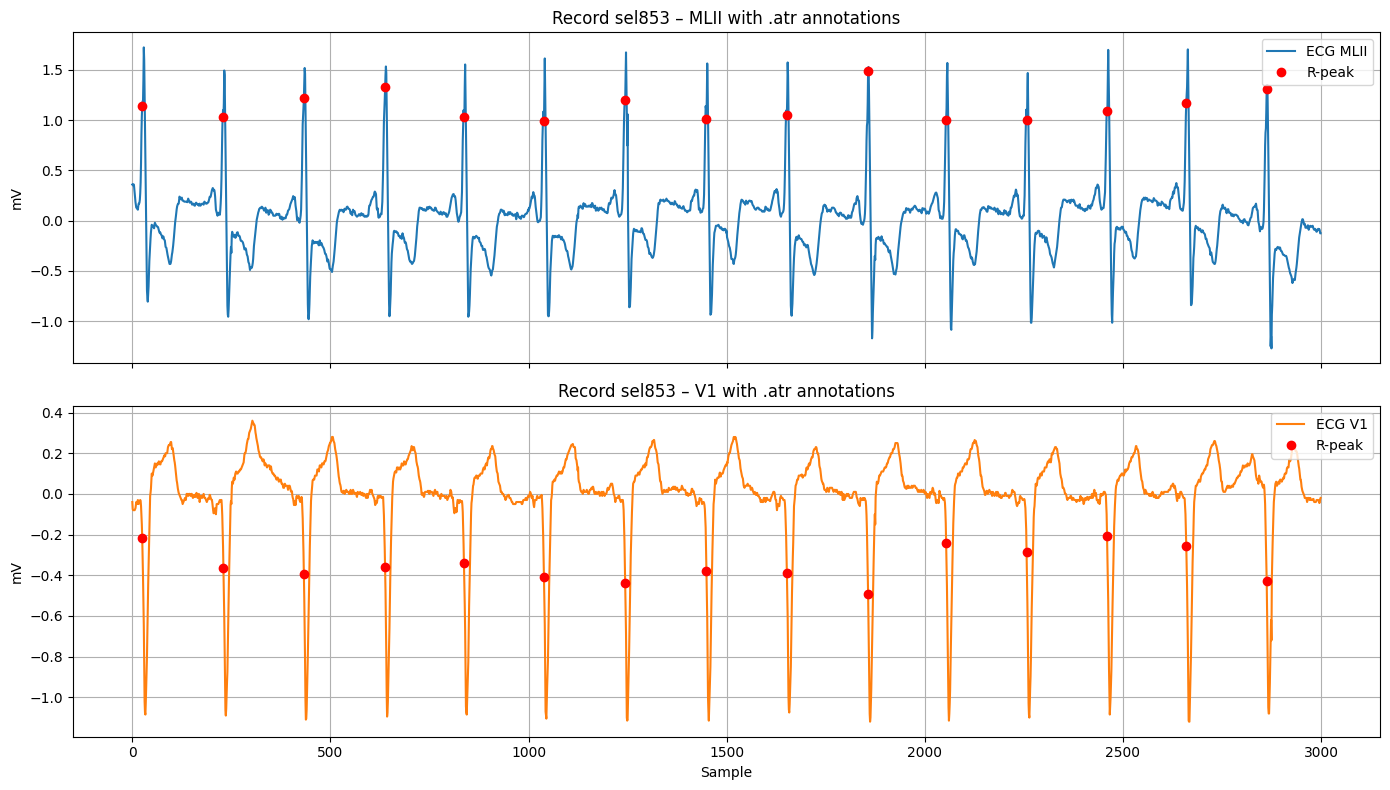

In [ ]:
# Specify the record to load
record_id   = 'sel853'
record_path = f'{qt_db_path}{record_id}'

# 1) Load ECG signal and .atr annotations
record  = wfdb.rdrecord(record_path)
atr_ann = wfdb.rdann(record_path, 'atr')

samples = atr_ann.sample
symbols = atr_ann.symbol

# 2) Define visualization interval
start, end = 0, 3000  # samples (adjust as needed)

# 3) Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot MLII on the first axis
ax1.plot(range(start, end), record.p_signal[start:end, 0], label='ECG MLII')
ax1.set_ylabel('mV')
ax1.set_title(f'Record {record_id} – MLII with .atr annotations')
ax1.grid()
for s in samples:
    if start <= s < end:
        ax1.plot(s, record.p_signal[s, 0], 'ro',
                 label='R-peak' if 'R-peak' not in ax1.get_legend_handles_labels()[1] else "")
ax1.legend(loc='upper right')

# Plot V1 on the second axis
ax2.plot(range(start, end), record.p_signal[start:end, 1], label='ECG V1', color='tab:orange')
ax2.set_xlabel('Sample')
ax2.set_ylabel('mV')
ax2.set_title(f'Record {record_id} – V1 with .atr annotations')
ax2.grid()
for s in samples:
    if start <= s < end:
        ax2.plot(s, record.p_signal[s, 1], 'ro',
                 label='R-peak' if 'R-peak' not in ax2.get_legend_handles_labels()[1] else "")
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


### Visualizing Automatically Detected P-Wave Onsets (.pu0 and .pu1)

In this step, we visualize the P-wave onset annotations automatically generated by the `ecgpuwave` algorithm, using the `.pu0` and `.pu1` files from the QT Database.

- `.pu0` contains waveform onset and offset annotations for channel MLII (signal 0).
- `.pu1` contains similar annotations for channel V1 (signal 1).

We display a 12-second segment of the ECG signals for both channels, highlighting the automatically detected P-wave onsets.


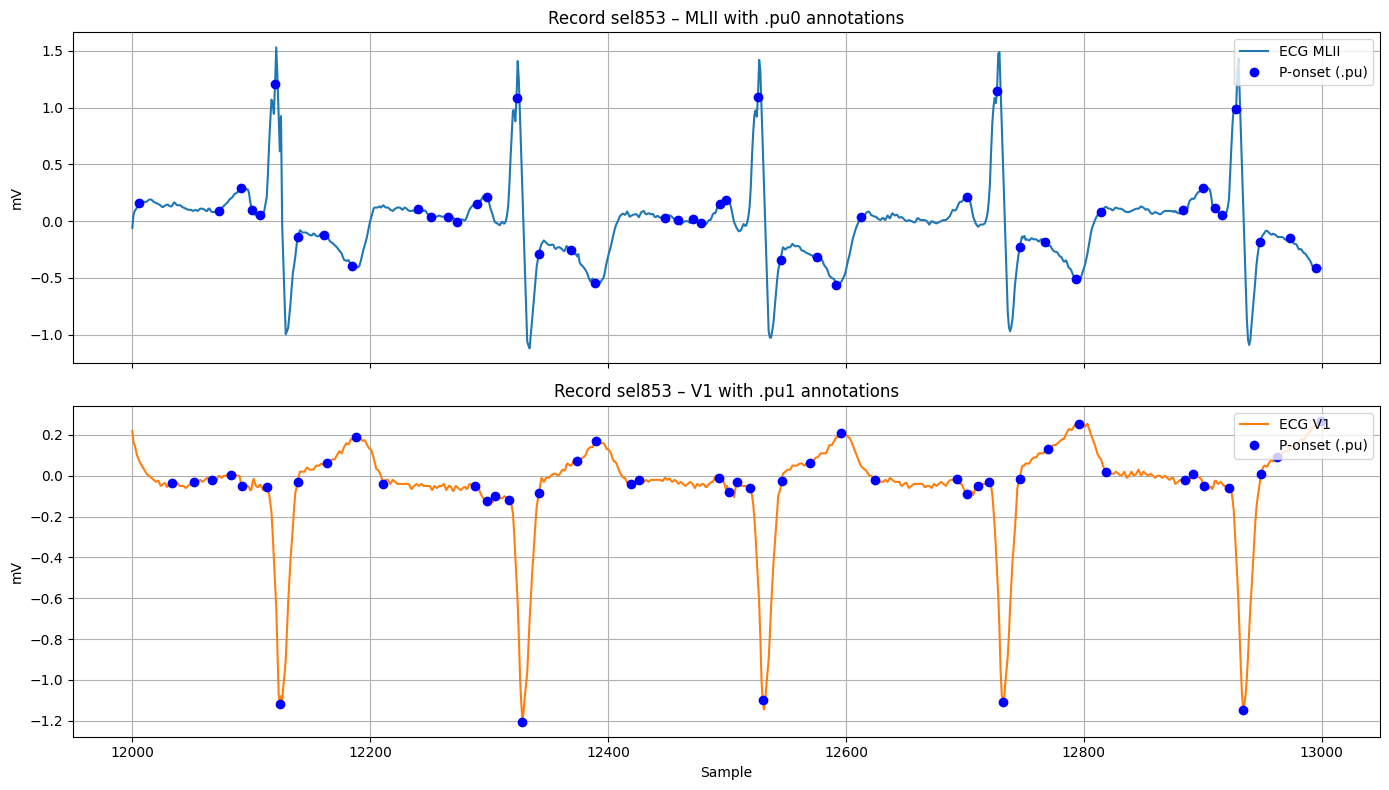

In [ ]:
# Specify the record to load
record_id   = 'sel853'
record_path = f'{qt_db_path}{record_id}'

# 1) Read signal and .pu annotations
record = wfdb.rdrecord(record_path)
pu0_ann = wfdb.rdann(record_path, 'pu0')  # channel 0 (MLII)
pu1_ann = wfdb.rdann(record_path, 'pu1')  # channel 1 (V1)
pu0_samples = pu0_ann.sample
pu0_symbols = pu0_ann.symbol
pu1_samples = pu1_ann.sample
pu1_symbols = pu1_ann.symbol

# 2) Define the display interval
start, end = 12000, 13000  # ~12 seconds window

# 3) Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot MLII (channel 0)
ax1.plot(range(start, end), record.p_signal[start:end, 0], label='ECG MLII')
ax1.set_ylabel('mV')
ax1.set_title(f'Record {record_id} – MLII with .pu0 annotations')
ax1.grid()
for s in pu0_samples:
    if start <= s < end:
        ax1.plot(s, record.p_signal[s, 0], 'bo',
                 label='P-onset (.pu)' if 'P-onset (.pu)' not in ax1.get_legend_handles_labels()[1] else "")
ax1.legend(loc='upper right')

# Plot V1 (channel 1)
ax2.plot(range(start, end), record.p_signal[start:end, 1], label='ECG V1', color='tab:orange')
ax2.set_xlabel('Sample')
ax2.set_ylabel('mV')
ax2.set_title(f'Record {record_id} – V1 with .pu1 annotations')
ax2.grid()
for s in pu1_samples:
    if start <= s < end:
        ax2.plot(s, record.p_signal[s, 1], 'bo',
                 label='P-onset (.pu)' if 'P-onset (.pu)' not in ax2.get_legend_handles_labels()[1] else "")
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


### Comparing Manual R-Peak Annotations (.atr) with Automatically Detected P-Wave Onsets (.pu)

In this step, we compare the `.atr` annotations—manually labeled R-peaks—with the `.pu0` and `.pu1` files, which contain P-wave onset positions automatically detected using the `ecgpuwave` algorithm.

By plotting both annotation types over the ECG signals from MLII and V1, we can visually validate the consistency and correctness of the `.atr` file. This comparison provides a layer of quality assurance before using the annotations in downstream classification tasks.


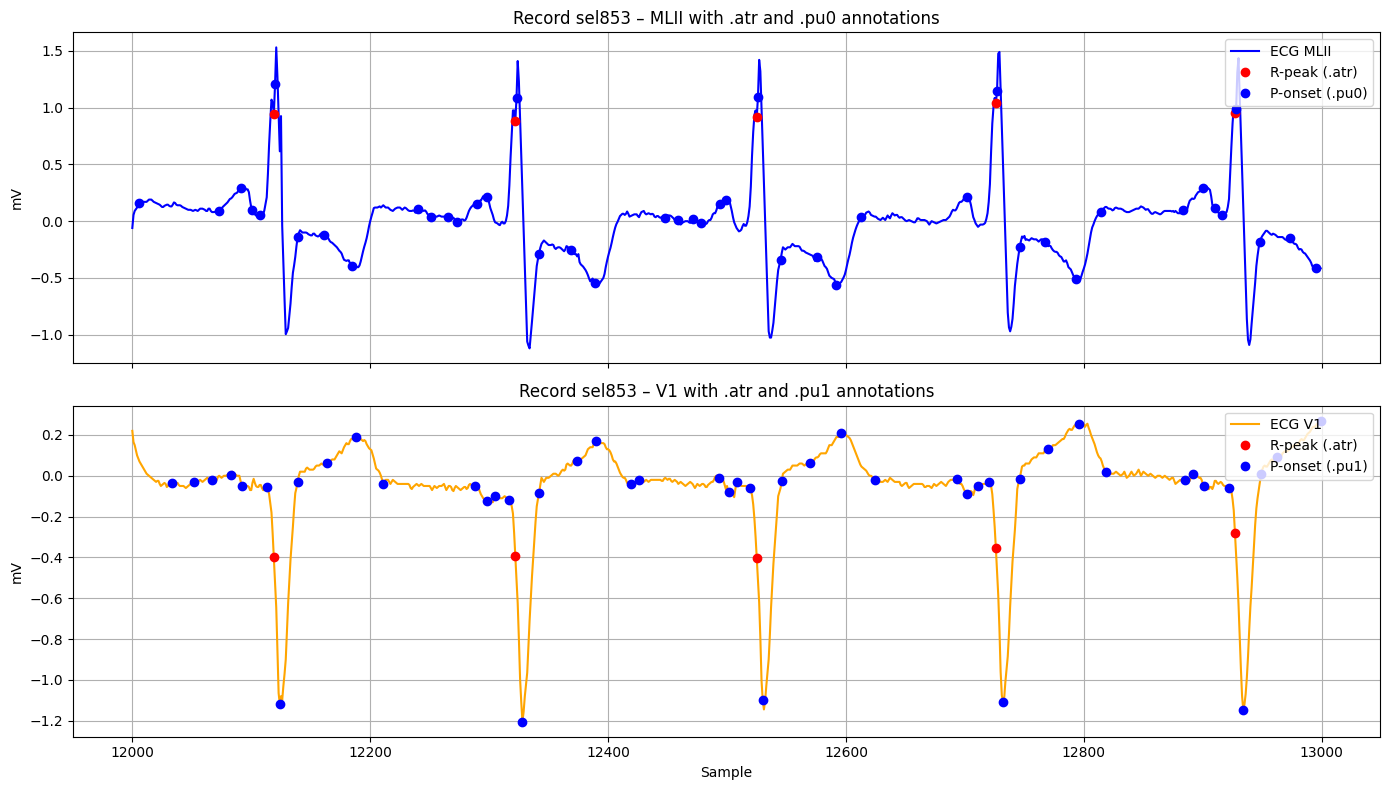

In [ ]:
# Specify the record to load
record_id = 'sel853'
record_path = f'{qt_db_path}{record_id}'

# 1) Load signal and annotations from .atr, .pu0, and .pu1
record = wfdb.rdrecord(record_path)
atr_ann = wfdb.rdann(record_path, 'atr')   # R-peak annotations from .atr
pu0_ann = wfdb.rdann(record_path, 'pu0')   # P-wave onsets for MLII from .pu0
pu1_ann = wfdb.rdann(record_path, 'pu1')   # P-wave onsets for V1 from .pu1

# 2) Extract all R-peaks (not just 'N' type)
all_peaks = [s for s in atr_ann.sample]

# 3) Extract P-wave onsets from .pu0 and .pu1
p_onsets_mlii = pu0_ann.sample
p_onsets_v1 = pu1_ann.sample

# Display interval (first 1000 samples)
start, end = 12000, 13000

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# 4) Plot MLII (channel 0)
ax1.plot(range(start, end), record.p_signal[start:end, 0], label='ECG MLII', color='blue')
ax1.set_ylabel('mV')
ax1.set_title(f'Record {record_id} – MLII with .atr and .pu0 annotations')
ax1.grid()

# Flags for legend entries
peak_legend_added = False
p_legend_added = False

# Plot R-peaks from .atr on MLII
for s in all_peaks:
    if start <= s < end:
        ax1.plot(s, record.p_signal[s, 0], 'ro', label='R-peak (.atr)' if not peak_legend_added else "")
        peak_legend_added = True

# Plot P-onsets from .pu0 on MLII
for s in p_onsets_mlii:
    if start <= s < end:
        ax1.plot(s, record.p_signal[s, 0], 'bo', label='P-onset (.pu0)' if not p_legend_added else "")
        p_legend_added = True

ax1.legend(loc='upper right')

# 5) Plot V1 (channel 1)
ax2.plot(range(start, end), record.p_signal[start:end, 1], label='ECG V1', color='orange')
ax2.set_xlabel('Sample')
ax2.set_ylabel('mV')
ax2.set_title(f'Record {record_id} – V1 with .atr and .pu1 annotations')
ax2.grid()

# Reset flags
peak_legend_added = False
p_legend_added = False

# Plot R-peaks from .atr on V1
for s in all_peaks:
    if start <= s < end:
        ax2.plot(s, record.p_signal[s, 1], 'ro', label='R-peak (.atr)' if not peak_legend_added else "")
        peak_legend_added = True

# Plot P-onsets from .pu1 on V1
for s in p_onsets_v1:
    if start <= s < end:
        ax2.plot(s, record.p_signal[s, 1], 'bo', label='P-onset (.pu1)' if not p_legend_added else "")
        p_legend_added = True

ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In the figure above, we visualize both the manually annotated **R-peaks** (red dots, from `.atr`) and the automatically detected **P-wave onsets** (blue dots, from `.pu0`/`.pu1`) over the MLII and V1 ECG leads for patient `sel853`.

While the red and blue markers do not always fall on *exactly* the same sample, they are consistently located around the apex of the QRS complex—where the R-peak typically occurs. This visual alignment suggests that the automatic detection is reasonably accurate for our use case.

In the next steps, we'll explain how we handled and refined these annotations for training our classification model.


---
## Data Preparation



### 1. Verifying Missing `.atr` Files

As mentioned in the official documentation and referenced papers describing the QT Database, not all patient records include a corresponding `.atr` annotation file. In particular, `.atr` files are missing for the 24 records associated with sudden cardiac death cases.

Since our classification work relies on the `.atr` files for reference annotations (e.g., R-peak positions), it is important to identify which records are missing this file type and remove them from the dataset.

In the following steps, we:
1. Automatically scan all records to find those that are missing `.atr` files.
2. Remove those incomplete records from the dataset to ensure only usable data remains.


In [ ]:
# Get all record names (without extension) in the folder
all_files = [f.split(".")[0] for f in os.listdir(qt_db_path) if f.endswith('.dat')]

# List of records missing a corresponding .atr file
files_without_atr = []

# Check if the .atr file exists for each record
for record in all_files:
    atr_file = os.path.join(qt_db_path, f'{record}.atr')
    if not os.path.exists(atr_file):  # If the .atr file does not exist
        files_without_atr.append(record)

# Print records without associated .atr
print("Files without corresponding .atr:")
for file in files_without_atr:
    print(file)

Files without corresponding .atr:


In [ ]:
# List of files without the .atr file
files_without_atr = [
    'sel33', 'sel35', 'sel43', 'sel46', 'sel51', 'sel34', 'sel48', 'sel39',
    'sel45', 'sel30', 'sel47', 'sel44', 'sel37', 'sel40', 'sel36', 'sel52',
    'sel32', 'sel49', 'sel42', 'sel31', 'sel41', 'sel50', 'sel38', 'sel100'
]

# Delete the .dat and .hea files for records missing the .atr file
for record in files_without_atr:
    dat_file = os.path.join(qt_db_path, f'{record}.dat')
    hea_file = os.path.join(qt_db_path, f'{record}.hea')

    # Check if the files exist and remove them
    if os.path.exists(dat_file):
        os.remove(dat_file)
        print(f"Deleted file: {dat_file}")

    if os.path.exists(hea_file):
        os.remove(hea_file)
        print(f"Deleted file: {hea_file}")

print("Cleanup completed.")

Cleanup completed.


### 2. Exploring Beat Annotation Symbols

Before labeling the heartbeats as **normal** or **abnormal**, it's important to verify all the possible values that the `.atr` annotation files can contain.

Each `.atr` file includes a list of symbols associated with detected events in the ECG signal. These symbols can represent different types of beats or markers.

Let's extract and print all the **unique annotation symbols** found across the entire QT database.


In [ ]:
# Find all records that have a .hea file
records = [f.split('.')[0] for f in os.listdir(qt_db_path) if f.endswith('.hea')]

# Set to collect all unique annotation symbols
unique_symbols = set()

for record_id in records:
    record_path = os.path.join(qt_db_path, record_id)

    try:
        ann = wfdb.rdann(record_path, 'atr')  # Read .atr annotation file
        unique_symbols.update(ann.symbol)    # Add symbols to the set
    except Exception as e:
        print(f"Skipping {record_id} due to error: {e}")

print(f"✅ Unique annotation symbols found in the QTDB: {sorted(unique_symbols)}")


✅ Unique annotation symbols found in the QTDB: ['"', '+', '/', 'A', 'F', 'J', 'N', 'Q', 'R', 'S', 'T', 'V', 'a', 'e', 'f', 'j', 's', '|', '~']


### Annotation Symbols in QTDB (for Beat Classification)

| Symbol | Description                              | Label to Use        |
|--------|------------------------------------------|---------------------|
| N      | Normal beat                              |  Normal           |
| L      | Left bundle branch block beat            |  Abnormal         |
| R      | Right bundle branch block beat           |  Abnormal         |
| A      | Atrial premature beat                    |  Abnormal         |
| a      | Aberrated atrial premature beat          |  Abnormal         |
| J      | Nodal (junctional) beat                  |  Abnormal         |
| S      | Supraventricular premature beat          |  Abnormal         |
| V      | Premature ventricular contraction (PVC)  |  Abnormal         |
| F      | Fusion of ventricular and normal beat    |  Abnormal         |
| e      | Atrial escape beat                       |  Abnormal         |
| j      | Nodal escape beat                        |  Abnormal         |
| f      | Fusion of paced and normal beat          |  Abnormal         |
| s      | Supraventricular escape beat             |  Abnormal         |
| Q      | Unknown beat                             |  Abnormal         |
| /      | Non-beat marker (e.g., segment boundary) |  Ignore           |
| +      | Rhythm change annotation                 |  Ignore           |
| ~      | Signal artifact or noise                 |  Ignore           |
| "      | Comment (not a beat)                     |  Ignore           |
| \|      | Isolated marker                          |  Ignore           |


### Creating Simplified `.atm` Annotations for Classification

In this step, we generate a simplified annotation file (`.atm`) for each ECG record based on the original `.atr` annotations. Here's what the script does:

1. **Loads all records with a `.hea` header file** to identify valid entries.
2. **Loops through each record** and reads both the signal and the `.atr` annotations.
3. **Filters the annotations** by keeping only alphabetic beat labels (A-Z), which correspond to actual heartbeat types.
   - The label `'N'` (Normal beat) is kept as is.
   - All other beat types are relabeled as `'A'` (Abnormal), creating a binary classification setup.
4. **Saves a new `.atm` annotation file** only if valid beats are found, using the simplified binary labels.
5. **Logs** the result for each record, indicating whether a new file was created or skipped.

This preprocessing step standardizes the annotation format across all records and prepares the data for training a binary classifier (Normal vs Abnormal).


In [ ]:
# Find all records with a .hea file
records_with_hea = sorted([
    f.split('.')[0] for f in os.listdir(qt_db_path) if f.endswith('.hea')
])

# Loop through all records
for record_id in records_with_hea:
    record_path = os.path.join(qt_db_path, record_id)

    try:
        # Read signal and .atr annotations
        record = wfdb.rdrecord(record_path)
        atr_ann = wfdb.rdann(record_path, 'atr')

        filtered_samples = []
        filtered_symbols = []

        # Filter symbols: keep only alphabetic ones (A-Z)
        for s, sym in zip(atr_ann.sample, atr_ann.symbol):
            if sym.isalpha():  # Only alphabetic symbols
                if sym == 'N':
                    filtered_symbols.append('N')  # Normal
                else:
                    filtered_symbols.append('A')  # Any other letter = Abnormal
                filtered_samples.append(int(s))  # Ensure base int conversion

        # Save new .atm file only if valid beats were found
        if len(filtered_samples) > 0:
            wfdb.wrann(
                record_id,
                'atm',
                sample=np.array(filtered_samples, dtype=int),  #Convert to int ndarray
                symbol=filtered_symbols,
                write_dir=qt_db_path
            )

            new_atr_path = os.path.join(qt_db_path, f'{record_id}.atm')
            print(f" {record_id}: File saved ➜ Filtered beats: {len(filtered_samples)}")

        else:
            print(f" {record_id}: No valid beats found, skipping .atm save")

    except Exception as e:
        print(f" Error in {record_id}: {e}")

print("\n Processing completed for all records!")


 sel102: File saved ➜ Filtered beats: 1
 sel103: File saved ➜ Filtered beats: 1048
 sel104: File saved ➜ Filtered beats: 349
 sel114: File saved ➜ Filtered beats: 862
 sel116: File saved ➜ Filtered beats: 1185
 sel117: File saved ➜ Filtered beats: 766
 sel123: File saved ➜ Filtered beats: 756
 sel14046: File saved ➜ Filtered beats: 1260
 sel14157: File saved ➜ Filtered beats: 1081
 sel14172: File saved ➜ Filtered beats: 663
 sel15814: File saved ➜ Filtered beats: 1036
 sel16265: File saved ➜ Filtered beats: 1031
 sel16272: File saved ➜ Filtered beats: 851
 sel16273: File saved ➜ Filtered beats: 1112
 sel16420: File saved ➜ Filtered beats: 1063
 sel16483: File saved ➜ Filtered beats: 1087
 sel16539: File saved ➜ Filtered beats: 922
 sel16773: File saved ➜ Filtered beats: 1008
 sel16786: File saved ➜ Filtered beats: 925
 sel16795: File saved ➜ Filtered beats: 761
 sel17152: File saved ➜ Filtered beats: 1628
 sel17453: File saved ➜ Filtered beats: 1047
 sel213: File saved ➜ Filtered beats

***Why Does Patient `sel102` Have Only 1 Saved Beat?***

In [ ]:
record_id = 'sel102'
record_path = os.path.join(qt_db_path, record_id)

ann = wfdb.rdann(record_path, 'atr')

print(f"\nUnique symbols in {record_id}: {set(ann.symbol)}")
print(f"Total original annotations: {len(ann.symbol)}")

# Count how many are letters
letter_symbols = [s for s in ann.symbol if s.isalpha()]
print(f"Total isalpha() annotations: {len(letter_symbols)}")

# Show the first 50 original symbols
print(f"First 50 symbols: {ann.symbol[:50]}")


Unique symbols in sel102: {'V', '/'}
Total original annotations: 1088
Total isalpha() annotations: 1
First 50 symbols: ['/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/', '/']


**Explanation:**  
In the case of `sel102`, we see that almost all annotations are `/` (a non-beat technical marker).  
Only one annotation (`'V'`) corresponds to a heartbeat.  

Since we only retain symbols that are **alphabetic characters (A–Z)** for beat classification,  
it's expected that only **one valid beat** is kept.


Let's see another example:

In [ ]:
# Define the path
record_id = 'sel104'
record_path = f'/content/drive/MyDrive/DL_Project/qt-database-1.0.0/qt-database-1.0.0/{record_id}'

# Load original .atr annotations
atr_ann = wfdb.rdann(record_path, 'atr')

# Load filtered .atm annotations
atm_ann = wfdb.rdann(record_path, 'atm')

# ----- Compare annotation symbols -----
print(f"Record: {record_id}")

# Original .atr info
print("\n--- Original (.atr) ---")
print(f"Unique symbols: {sorted(set(atr_ann.symbol))}")
print(f"Total annotations: {len(atr_ann.symbol)}")
print(f"First 50 symbols: {atr_ann.symbol[:50]}")

# Filtered .atm info
print("\n--- Filtered (.atm) ---")
print(f"Unique symbols: {sorted(set(atm_ann.symbol))}")
print(f"Total annotations: {len(atm_ann.symbol)}")
print(f"First 50 filtered symbols: {atm_ann.symbol[:50]}")


Record: sel104

--- Original (.atr) ---
Unique symbols: ['+', '/', 'N', 'V', 'f']
Total annotations: 1113
First 50 symbols: ['/', '/', '/', '/', '/', 'f', 'f', 'f', '/', '/', '/', '/', '/', 'f', 'f', 'f', '/', '/', '/', '/', '/', 'f', 'f', 'f', '/', '/', '/', '/', '/', 'f', 'f', 'f', 'V', '/', '/', '/', '/', 'f', 'f', 'f', '/', '/', '/', '/', '/', '/', 'f', 'f', 'f', 'f']

--- Filtered (.atm) ---
Unique symbols: ['A', 'N']
Total annotations: 349
First 50 filtered symbols: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'A', 'A', 'A', 'N', 'A', 'A', 'N', 'A', 'A', 'A', 'A', 'A', 'A']


###  Window-based Labeling for ECG Classification

In this step, we segment each ECG recording into 2-second windows and assign a label to each window based on the R-peaks it contains.

For each window:
- We detect the R-peaks using `.atr` annotations.
- We match each R-peak to its corresponding label (`N` for normal, or any other symbol marked as abnormal) from the `.atm` file.
- If at least one abnormal beat is found in the window, the entire window is labeled as **Abnormal**; otherwise, it is labeled as **Normal**.

The goal is to generate a labeled dataset of fixed-size ECG segments, ready for training and evaluation in the classification model.

This step also logs any unmatched R-peaks and exports the full list of labeled windows to a CSV file for downstream tasks.


In [ ]:
# Basic parameters
fs = 250  # Hz
window_size = 2  # seconds
samples_per_window = window_size * fs
match_tolerance = 10
total_missing = 0

# Data directory
data_dir = '/content/drive/MyDrive/DL_Project/qt-database-1.0.0/qt-database-1.0.0/'

# Find all records with .hea files
records_with_q1c = sorted([
    f.split('.')[0] for f in os.listdir(data_dir) if f.endswith('.hea')
])

windows_results = []

# Function to find matching annotation within tolerance
def find_label(r_peak, atm_samples, atm_symbols, tolerance=3):
    for s, sym in zip(atm_samples, atm_symbols):
        if abs(s - r_peak) <= tolerance:
            return sym
    return None  # No match found

# Loop through each record
for record_id in records_with_q1c:
    record_path = os.path.join(data_dir, record_id)

    try:
        atr_ann = wfdb.rdann(record_path, 'atr')
        r_peaks = atr_ann.sample

        atm_ann = wfdb.rdann(record_path, 'atm')
        atm_samples = atm_ann.sample
        atm_symbols = atm_ann.symbol

        record = wfdb.rdrecord(record_path)
        signal = record.p_signal

        for start_sample in range(0, len(signal) - samples_per_window + 1, samples_per_window):
            end_sample = start_sample + samples_per_window

            r_peaks_in_window = [r for r in r_peaks if start_sample <= r < end_sample]

            window_labels = []
            for r_peak in r_peaks_in_window:
                label = find_label(r_peak, atm_samples, atm_symbols, tolerance=match_tolerance)

                if label is None:
                    total_missing += 1
                    continue

                if label == 'N':
                    window_labels.append('Normal')
                elif label == 'A':
                    window_labels.append('Abnormal')

            if window_labels:
                window_label = 'Abnormal' if 'Abnormal' in window_labels else 'Normal'
                windows_results.append({
                    'record': record_id,
                    'window_start': start_sample,
                    'window_end': end_sample,
                    'label': window_label,
                    'r_peaks': r_peaks_in_window
                })

    except Exception as e:
        print(f" ERROR in {record_id}: {e}")

# Save and show statistics
windows_df = pd.DataFrame(windows_results)

print(f"\n TOTAL WINDOWS CREATED: {len(windows_results)}")
print(windows_df['label'].value_counts())
print(f" TOTAL R-peaks ignored: {total_missing}")
print(windows_df.head(30))

# Save to CSV
windows_df.to_csv('/content/record_windows.csv', index=False)



 TOTAL WINDOWS CREATED: 35690
label
Normal      32343
Abnormal     3347
Name: count, dtype: int64
 TOTAL R-peaks ignored: 2560
    record  window_start  window_end     label                r_peaks
0   sel102         54000       54500  Abnormal  [54125, 54265, 54475]
1   sel103             0         500    Normal         [14, 184, 399]
2   sel103           500        1000    Normal             [608, 819]
3   sel103          1000        1500    Normal     [1029, 1246, 1477]
4   sel103          1500        2000    Normal           [1697, 1905]
5   sel103          2000        2500    Normal           [2113, 2324]
6   sel103          2500        3000    Normal     [2532, 2745, 2973]
7   sel103          3000        3500    Normal           [3200, 3429]
8   sel103          3500        4000    Normal           [3649, 3875]
9   sel103          4000        4500    Normal           [4091, 4316]
10  sel103          4500        5000    Normal     [4550, 4772, 4984]
11  sel103          5000        

This output shows the final statistics after labeling 2-second windows of ECG data based on beat annotations:

Total Windows Created: **35690** — Each window contains one or more R-peaks and has been labeled either as Normal or Abnormal depending on the beats inside.

- **Normal Windows: 32343**

- **Abnormal Windows: 3347**

- **Total R-peaks Ignored: 2,560**

This means that 2,560 R-peaks from the .atr files did not match any beat in the .atm annotations (even within a ±10 sample tolerance). These unmatched peaks were skipped and not used for window labeling.


The `.atm` files were created by filtering only alphabetic symbols (`A–Z`) from the original `.atr` annotations. Any non-alphabetic symbols (like `'/'`, `'+'`, or `'~'`) were excluded, because they are **not heartbeat annotations**.
So, if some R-peaks were originally labeled with such symbols, they:

- Were **not included** in the `.atm` file,  
- And therefore, could **not be matched** during window labeling,  
- Leading to them being **counted as ignored R-peaks**.

This reinforces that the filtering step worked as intended — only valid, classifiable beats (Normal or Abnormal) were retained.



---
**Visualizing Beat Labels from `.atm` Files**

In this step, we visualize the ECG signal from both leads (MLII and V1) along with the annotated beat labels from the `.atm` file. These labels were previously filtered and classified as either `'N'` for normal or `'A'` for abnormal beats.

The code extracts a 2-second window (500 samples at 250 Hz) from the beginning of the recording and overlays the annotations directly on the ECG trace. This allows for a clear view of:

- The morphology of each beat  
- The exact position of the annotation  
- The label assigned to that beat
- The label assigned to the window (on the following code)  

This visual check helps verify that the annotation process worked correctly and that the retained beat labels align properly with the corresponding peaks in both channels.


Full signal shape: (225000, 2)
Window shape: (500, 2)


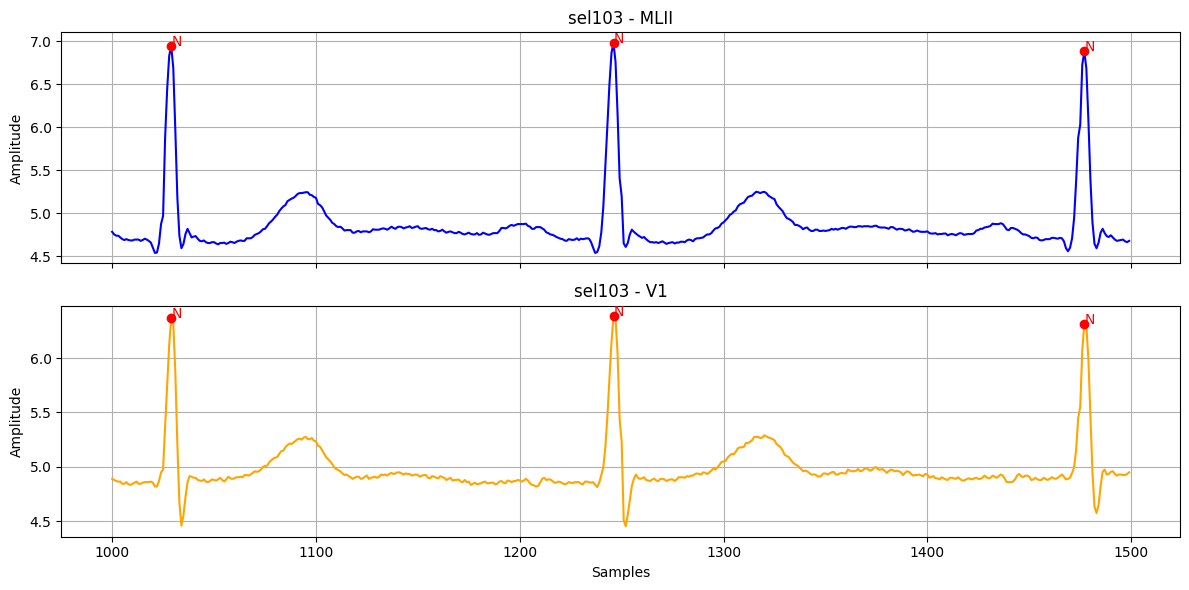

In [ ]:
# Specify the record to load
record_id = 'sel103'  # Change this to the record you want to visualize
record_path = os.path.join(data_dir, record_id)

# 1) Load ECG signal
record = wfdb.rdrecord(record_path)
signal = record.p_signal
print("Full signal shape:", signal.shape)

# 2) Load annotations
atm_ann = wfdb.rdann(record_path, 'atm')
atm_samples = atm_ann.sample
atm_symbols = atm_ann.symbol

# 3) Define window
start_sample = 1000
end_sample = start_sample + 2 * 250
window_signal = signal[start_sample:end_sample, :]   # use both channels
print("Window shape:", window_signal.shape)

# 4) Dual plot
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axs[0].plot(np.arange(start_sample, end_sample), window_signal[:, 0], label='MLII', color='blue')
axs[0].set_title(f"{record_id} - MLII")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True)
for sample, symbol in zip(atm_samples, atm_symbols):
    if start_sample <= sample < end_sample:
        y0 = window_signal[sample - start_sample, 0]
        axs[0].plot(sample, y0, 'ro')
        axs[0].text(sample, y0, symbol, color='red', fontsize=10)

axs[1].plot(np.arange(start_sample, end_sample), window_signal[:, 1], label='V1', color='orange')
axs[1].set_title(f"{record_id} - V1")
axs[1].set_xlabel("Samples")
axs[1].set_ylabel("Amplitude")
axs[1].grid(True)
for sample, symbol in zip(atm_samples, atm_symbols):
    if start_sample <= sample < end_sample:
        y1 = window_signal[sample - start_sample, 1]
        axs[1].plot(sample, y1, 'ro')
        axs[1].text(sample, y1, symbol, color='red', fontsize=10)

plt.tight_layout()
plt.show()


Look the label of this window:

In [ ]:
# Find R-peaks within the window
r_peaks_in_window = [s for s in atm_samples if start_sample <= s < end_sample]

labels_in_window = []
for s in r_peaks_in_window:
    idx = list(atm_samples).index(s)
    labels_in_window.append(atm_symbols[idx])

# Force conversion of each element to integer
r_peaks_in_window = [int(x) for x in r_peaks_in_window]
print(" R-peak positions:", r_peaks_in_window)

print(" Labels of the peaks:", labels_in_window)

# Determine window label
if labels_in_window:
    if 'A' in labels_in_window:
        window_label = 'Abnormal'
    else:
        window_label = 'Normal'
        print(f"\n Final label for this window: {window_label}")
else:
    print("\n Window discarded: no beats inside.")
    window_label = None

 R-peak positions: [1029, 1246, 1477]
 Labels of the peaks: ['N', 'N', 'N']

 Final label for this window: Normal


**This output confirmed that our idea works.**

---
##  Data Preprocessing


### Data Loading and Preparation

In this section, we load the data from the CSV file where the ECG windows were saved. We removed the `label` column from the **windows** dataset because we use it as the target variable **y**. The **X** variable will contain the features extracted from the ECG windows.

The following code demonstrates how to load the data, separate the features **X** and labels **y**, and display the shape of the loaded data.


In [ ]:
# Step 1: Load the data from the CSV file where windows were saved
import pandas as pd

# Load the windows data
windows_df = pd.read_csv('/content/record_windows.csv')

# Separate features (X) and labels (y)
X = windows_df.drop(columns=['label']).values  # Features
y = windows_df['label'].values  # Labels

print("Data loaded:", X.shape, y.shape)


Data loaded: (35690, 4) (35690,)


### Data Splitting and Normalization

This section of the code performs the following steps:

1. **Load the data**: The ECG windows are loaded from a CSV file, and features (X) and labels (y) are separated.
2. **Preprocessing**: The ECG data is filtered using a notch filter to remove 50Hz power line interference and a band-pass filter to retain relevant ECG frequencies (0.5–40Hz).
3. **Data Splitting**: The data is split into **Training**, **Validation**, and **Test** sets using a stratified approach to maintain class distribution.
4. **Normalization**: Z-score normalization is applied only to the **Training set**. The same normalization is then applied to the **Validation** and **Test** sets.
5. **Save Preprocessed Data**: The normalized data is saved in a compressed `.npz` file for future use.

The data distribution before and after normalization is printed for each set.


In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, iirnotch
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Paths
data_dir    = '/content/drive/MyDrive/DL_Project/qt-database-1.0.0/qt-database-1.0.0/'
windows_csv = '/content/record_windows.csv'
out_npz     = '/content/drive/MyDrive/X_y_preprocessed.npz'

# 1) Check if the .npz file already exists
if os.path.exists(out_npz):
    print("Preprocessed data loaded from disk.")
    data = np.load(out_npz)
    X_train, X_val, X_test = data['X_train'], data['X_val'], data['X_test']
    y_train, y_val, y_test = data['y_train'], data['y_val'], data['y_test']
    print("Shape X_train:", X_train.shape, "Shape y_train:", y_train.shape)
else:
    print("No preprocessed data found. Running preprocessing...")

    # 2) Define preprocessing function
    def preprocess_ecg(sig, fs=250):
        # Notch filter at 50Hz to remove power line interference
        b_n, a_n = iirnotch(50, 30, fs)
        sig = filtfilt(b_n, a_n, sig)
        # Band-pass filter between 0.5–40Hz to keep ECG relevant frequencies
        b_bp, a_bp = butter(4, [0.5/(fs/2), 40/(fs/2)], btype='band')
        return filtfilt(b_bp, a_bp, sig)

    # 3) Load window table from CSV
    windows_df = pd.read_csv(windows_csv)

    X_list, y_list = [], []

    fs = 250  # Sampling frequency

    # 4) Loop over each row in windows_df, filter and normalize each window
    for _, row in tqdm(windows_df.iterrows(), total=len(windows_df), desc="Preprocessing + Z-score"):
        rec   = row['record']
        start = int(row['window_start'])
        end   = int(row['window_end'])
        lbl   = row['label']

        # Read the ECG record
        record = wfdb.rdrecord(os.path.join(data_dir, rec))
        sig0   = record.p_signal[start:end, 0]
        sig1   = record.p_signal[start:end, 1]

        # Apply filters to ECG channels
        f0 = preprocess_ecg(sig0, fs)
        f1 = preprocess_ecg(sig1, fs)

        # Stack channels → shape (500, 2)
        w = np.stack([f0, f1], axis=1)
        assert w.shape == (500, 2), f"Invalid window shape: {w.shape}"

        # Save the filtered window and its corresponding label
        X_list.append(w)
        y_list.append(0 if lbl == 'Normal' else 1)

    # 5) Convert to final arrays (stack the windows)
    X = np.stack(X_list)
    y = np.array(y_list)

    # 6) Split the data into train, validation, and test sets (stratified)
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.111111, random_state=42, stratify=y_temp)

    print("Training set (80%) distribution:")
    print(f"Normal: {np.sum(y_train == 0)}")
    print(f"Abnormal: {np.sum(y_train == 1)}")
    print("\nValidation set (10%) distribution:")
    print(f"Normal: {np.sum(y_val == 0)}")
    print(f"Abnormal: {np.sum(y_val == 1)}")
    print("\nTest set (10%) distribution:")
    print(f"Normal: {np.sum(y_test == 0)}")
    print(f"Abnormal: {np.sum(y_test == 1)}")

    # 7) Apply Z-score normalization only to the training set
    scaler = StandardScaler()

    # Calcola la normalizzazione sul training set (solo sui dati di addestramento)
    X_train_reshaped = X_train.reshape(-1, 2)  # Flatten per calcolare la normalizzazione su tutte le finestre
    scaler.fit(X_train_reshaped)  # Calcola media e deviazione standard sui dati di addestramento

    # Applica la normalizzazione ai dati di addestramento
    X_train_normalized = scaler.transform(X_train_reshaped).reshape(X_train.shape)

    # Applica la stessa normalizzazione ai dati di validazione e di test
    X_val_normalized = scaler.transform(X_val.reshape(-1, 2)).reshape(X_val.shape)
    X_test_normalized = scaler.transform(X_test.reshape(-1, 2)).reshape(X_test.shape)

    # 8) Save the normalized data to disk in a compressed .npz format
    np.savez(out_npz, X_train=X_train_normalized, X_val=X_val_normalized, X_test=X_test_normalized,
             y_train=y_train, y_val=y_val, y_test=y_test)

    print("Preprocessing + normalization completed and saved to disk.")
    print("Shape X_train:", X_train_normalized.shape, "Shape y_train:", y_train.shape)
    print("Shape X_val:", X_val_normalized.shape, "Shape y_val:", y_val.shape)
    print("Shape X_test:", X_test_normalized.shape, "Shape y_test:", y_test.shape)


No preprocessed data found. Running preprocessing...


Preprocessing + Z-score: 100%|██████████| 35690/35690 [11:36<00:00, 51.25it/s]


Training set (80%) distribution:
Normal: 25875
Abnormal: 2677

Validation set (10%) distribution:
Normal: 3234
Abnormal: 335

Test set (10%) distribution:
Normal: 3234
Abnormal: 335
Preprocessing + normalization completed and saved to disk.
Shape X_train: (28552, 500, 2) Shape y_train: (28552,)
Shape X_val: (3569, 500, 2) Shape y_val: (3569,)
Shape X_test: (3569, 500, 2) Shape y_test: (3569,)


Look the results:

In [ ]:
import numpy as np

# Path to the preprocessed file
out_npz = '/content/drive/MyDrive/X_y_preprocessed.npz'

# Load the preprocessed data
data = np.load(out_npz)

# Access the arrays stored in the file
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']

# Print shapes to verify
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of y_test: {y_test.shape}")

# You can also inspect the first example
print("First example of X_train:", X_train[0])
print("First label of y_train:", y_train[0])


Shape of X_train: (28552, 500, 2)
Shape of X_val: (3569, 500, 2)
Shape of X_test: (3569, 500, 2)
Shape of y_train: (28552,)
Shape of y_val: (3569,)
Shape of y_test: (3569,)
First example of X_train: [[ 9.40866558e-01 -4.29136003e-01]
 [ 8.16582050e-01 -5.39408057e-01]
 [ 7.40925367e-01 -6.49872975e-01]
 [ 7.17499136e-01 -7.53831186e-01]
 [ 7.04539414e-01 -8.37490879e-01]
 [ 6.58112750e-01 -8.88850589e-01]
 [ 5.75743693e-01 -9.09764716e-01]
 [ 4.99214754e-01 -9.19110631e-01]
 [ 4.74519999e-01 -9.40813724e-01]
 [ 5.06125120e-01 -9.85503545e-01]
 [ 5.48559074e-01 -1.04222287e+00]
 [ 5.44845641e-01 -1.08764278e+00]
 [ 4.77113387e-01 -1.10441072e+00]
 [ 3.82729655e-01 -1.09305518e+00]
 [ 3.21776587e-01 -1.06885424e+00]
 [ 3.24156711e-01 -1.04877938e+00]
 [ 3.56995746e-01 -1.04059836e+00]
 [ 3.34164647e-01 -1.04109365e+00]
 [ 1.65115642e-01 -1.04177935e+00]
 [-1.78423749e-01 -1.03766057e+00]
 [-6.14723098e-01 -1.03503719e+00]
 [-9.61419359e-01 -1.05296302e+00]
 [-1.01081093e+00 -1.11344212e+

3. **Data Augmentation and Training Set Balancing**

  To address the imbalance between normal and abnormal windows in the training set, we perform two key steps:

    1️. **Data Augmentation**  
    We generate synthetic abnormal samples by applying random transformations to the original abnormal windows:
      - **Jittering**: Adding small Gaussian noise to simulate sensor variability.
      - **Scaling**: Randomly amplifying or attenuating the signal to introduce realistic variation.

 2️. **Balancing the Dataset**  
    After augmenting the abnormal windows, we balance the training set by:
      - Combining original and augmented abnormal windows.
      - **Undersampling** the normal windows to match the number of abnormal samples.
      - Shuffling the data to avoid order bias.

This procedure ensures a **balanced dataset (50% normal, 50% abnormal)**, which helps the model learn equally from both classes and prevents bias toward the majority class.


In [ ]:
import random
import numpy as np

# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# Augmentation function
def augment_signal(window, jitter_sigma=0.05, scale_sigma=0.1):
    augmented = np.copy(window)
    # Jitter (additive Gaussian noise)
    augmented += np.random.normal(0.0, jitter_sigma, size=augmented.shape)
    # Scaling (multiplicative Gaussian noise)
    scale = np.random.normal(1.0, scale_sigma, size=(1, augmented.shape[1]))
    augmented *= scale
    return augmented

# Balancing + augmentation
def balance_training(X_train, y_train, factor_abn=2):
    # Select the indices for normal and abnormal windows
    idx_norm = np.where(y_train == 0)[0]
    idx_abn  = np.where(y_train == 1)[0]

    print(f"Original Abnormal: {len(idx_abn)}")
    print(f"Original Normal: {len(idx_norm)}")

    # 1️) Generate augmented abnormal windows
    augmented_abn = []
    for _ in range(len(idx_abn) * factor_abn):  # Augmentation of abnormal windows
        w = X_train[np.random.choice(idx_abn)]
        w_aug = augment_signal(w)
        augmented_abn.append(w_aug)
    augmented_abn = np.stack(augmented_abn)

    # 2️) Combine original and augmented abnormal windows
    X_abn_final = np.concatenate([X_train[idx_abn], augmented_abn])
    y_abn_final = np.ones(len(X_abn_final))

    print(f"Total abnormal: {len(idx_abn)} original + {len(augmented_abn)} augmented = {len(X_abn_final)}")

    # 3️) Undersample the normal windows to match the size of the abnormal windows
    undersample_size = len(X_abn_final)
    undersampled_norm = X_train[np.random.choice(idx_norm, size=undersample_size, replace=False)]
    y_norm_final = np.zeros(undersample_size)

    # 4️) Combine and shuffle the data
    X_train_bal = np.concatenate([X_abn_final, undersampled_norm])
    y_train_bal = np.concatenate([y_abn_final, y_norm_final])

   # Random shuffling
    perm = np.random.permutation(len(y_train_bal))
    X_train_bal = X_train_bal[perm]
    y_train_bal = y_train_bal[perm]

    print(f"Balanced training set: {len(y_train_bal)} total | Normal={sum(y_train_bal==0)}, Abnormal={sum(y_train_bal==1)}")
    return X_train_bal, y_train_bal

# 5) Run the balancing function
X_train_bal, y_train_bal = balance_training(X_train, y_train, factor_abn=3)

# 6) Check the final class distribution
unique, counts = np.unique(y_train_bal, return_counts=True)
print("\nFinal balanced training distribution:")
for cls, count in zip(unique, counts):
    label = 'Normal' if cls == 0 else 'Abnormal'
    perc = 100 * count / len(y_train_bal)
    print(f" -> {label}: {count} windows ({perc:.2f}%)")
print(f"Total windows: {len(y_train_bal)}")


Original Abnormal: 2677
Original Normal: 25875
Total abnormal: 2677 original + 8031 augmented = 10708
Balanced training set: 21416 total | Normal=10708, Abnormal=10708

Final balanced training distribution:
 -> Normal: 10708 windows (50.00%)
 -> Abnormal: 10708 windows (50.00%)
Total windows: 21416


**Visualizing Data Augmentation Effects**

In this step, we compare an **original abnormal window** from the training set with its **augmented version**.

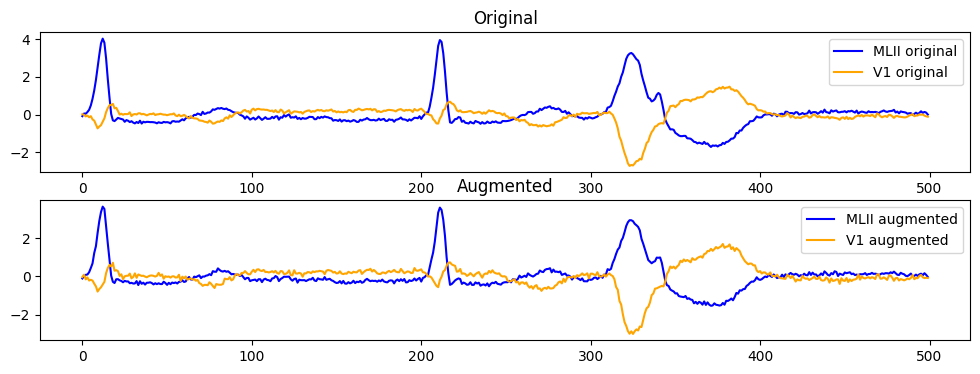

In [ ]:
import matplotlib.pyplot as plt

# Select an abnormal window from the balanced training set
idx_abn_bal = np.where(y_train_bal == 1)[0]

# Select the abnormal indices in the new balanced training set
idx = idx_abn_bal[8000]  # Choose a specific example (for example, the 8000th)
original = X_train_bal[idx]
augmented = augment_signal(original)

# Visualization of the comparison between the original window and the augmented one
plt.figure(figsize=(12, 4))

plt.subplot(2, 1, 1)
plt.plot(original[:, 0], label='MLII original', color='blue')
plt.plot(original[:, 1], label='V1 original', color='orange')
plt.title("Original")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(augmented[:, 0], label='MLII augmented', color='blue')
plt.plot(augmented[:, 1], label='V1 augmented', color='orange')
plt.title("Augmented")
plt.legend()

plt.show()


This visualization allows us to verify that the augmented signal remains realistic, while introducing controlled perturbations to improve model generalization.


---
## Hyperparameter Optimization with Keras Tuner




In this section, we perform hyperparameter optimization on the **ECG classification model** using **Keras Tuner**. The goal is to find the best combination of hyperparameters for the model, ensuring optimal performance for the task.

The model consists of three **Conv1D layers** for feature extraction, followed by **Global Average Pooling** and a **Dense layer** for classification. Key hyperparameters being tuned include:

1. **Filters and kernel sizes** for the convolutional layers.
2. **Number of units** in the dense layer.
3. **L2 regularization** for controlling overfitting.
4. **Dropout rate** to prevent overfitting during training.
5. **Learning rate** for the Adam optimizer.

We use **RandomSearch** for hyperparameter tuning, with the objective of maximizing **validation recall**. The search is performed over 30 trials, with 50 epochs per trial and early stopping for efficiency.

The following code sets up the hyperparameter search and trains the model with the best configurations found.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import keras_tuner as kt
from sklearn.utils import class_weight
import numpy as np

# Set input shape
input_shape = (500, 2)

# Function for building the model
def build_model(hp):
    model = models.Sequential()

    # First Conv1D layer
    model.add(layers.Conv1D(
        filters=hp.Int('conv1_filters', min_value=64, max_value=256, step=64),  # Expanded filter size
        kernel_size=hp.Choice('conv1_kernel', [3, 5, 7, 11]),  # Expanded kernel size
        padding='same',
        input_shape=input_shape
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling1D(2))

    # Second Conv1D layer
    model.add(layers.Conv1D(
        filters=hp.Int('conv2_filters', min_value=128, max_value=256, step=64),  # Expanded filter size
        kernel_size=hp.Choice('conv2_kernel', [3, 5, 7]),  # Expanded kernel size
        padding='same'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling1D(2))

    # Third Conv1D layer
    model.add(layers.Conv1D(
        filters=hp.Int('conv3_filters', min_value=128, max_value=256, step=64),  # Expanded filter size
        kernel_size=hp.Choice('conv3_kernel', [3, 5, 7]),  # Expanded kernel size
        padding='same'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling1D(2))

    # Global Average Pooling and Dense layers
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=128, max_value=256, step=64),  # Expanded dense units
        activation='relu',
        kernel_regularizer=regularizers.l2(
            hp.Float('l2', min_value=1e-5, max_value=1e-3, sampling='log')
        )
    ))

    # Dropout layer with expanded search range
    model.add(layers.Dropout(hp.Float('dropout', min_value=0.2, max_value=0.6, step=0.1)))  # Increased range

    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='AUC')]
    )

    return model

# Keras Tuner setup
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective('val_recall', direction='max'),
    max_trials=30,  # Increased number of trials
    executions_per_trial=1,
    directory='tuning_dir',
    project_name='ecg_tuning_extended'
)

# Summary of search space
tuner.search_space_summary()

# Start the tuning process with the extended parameters
tuner.search(
    X_train_bal, y_train_bal,
    epochs=50,  # Increased the number of epochs
    validation_data=(X_val, y_val),
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_recall', mode='max', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ]
)

# Results summary
tuner.results_summary()


Trial 30 Complete [00h 01m 39s]
val_recall: 0.89552241563797

Best val_recall So Far: 1.0
Total elapsed time: 01h 09m 24s
Results summary
Results in tuning_dir/ecg_tuning_extended
Showing 10 best trials
Objective(name="val_recall", direction="max")

Trial 09 summary
Hyperparameters:
conv1_filters: 192
conv1_kernel: 3
conv2_filters: 128
conv2_kernel: 3
conv3_filters: 192
conv3_kernel: 5
dense_units: 192
l2: 1.162911054826589e-05
dropout: 0.30000000000000004
lr: 0.006531232722772538
Score: 1.0

Trial 21 summary
Hyperparameters:
conv1_filters: 256
conv1_kernel: 11
conv2_filters: 128
conv2_kernel: 3
conv3_filters: 256
conv3_kernel: 5
dense_units: 128
l2: 0.0003630043814722362
dropout: 0.30000000000000004
lr: 0.007101054997544238
Score: 1.0

Trial 28 summary
Hyperparameters:
conv1_filters: 64
conv1_kernel: 5
conv2_filters: 256
conv2_kernel: 7
conv3_filters: 192
conv3_kernel: 3
dense_units: 192
l2: 1.5409404207370287e-05
dropout: 0.2
lr: 0.009644270859916792
Score: 1.0

Trial 06 summary
Hype

## Model Architecture and Training


In this section, we define and train a **static model** with optimized hyperparameters obtained from the previous tuning process. The model consists of three **Conv1D layers** for feature extraction, followed by **Global Average Pooling** and **Dense layers** for classification.

Key characteristics of the model include:
- **Conv1D layers** with optimized filter sizes and kernel sizes to capture relevant features from the ECG signals.
- **BatchNormalization** and **LeakyReLU** activations for better convergence and performance.
- **Dropout** to reduce overfitting during training.
- **L2 regularization** applied to the dense layer to prevent overfitting.
- **Learning rate** has been optimized for the Adam optimizer.

The model is compiled with **binary cross-entropy loss** and evaluated using metrics like **accuracy**, **precision**, **recall**, and **AUC**.

The training process includes **early stopping**, **learning rate reduction on plateau**, and **model checkpointing** to save the best performing model.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import numpy as np

# 1) Static model with optimized hyperparameters (from Trial 28)
input_shape = (500, 2)
model = models.Sequential([
    # First Conv1D layer: optimized filters=64, kernel_size=5
    layers.Conv1D(64, 5, padding='same', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.MaxPooling1D(2),

    # Second Conv1D layer: optimized filters=256, kernel_size=7
    layers.Conv1D(256, 7, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.MaxPooling1D(2),

    # Third Conv1D layer: optimized filters=192, kernel_size=3
    layers.Conv1D(192, 3, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.MaxPooling1D(2),

    # Global Average Pooling
    layers.GlobalAveragePooling1D(),

    # Dense layer with optimized units=192 and L2 regularization
    layers.Dense(
        192,
        activation='relu',
        kernel_regularizer=regularizers.l2(1.5409404207370287e-05)
    ),
    # Dropout layer with dropout=0.2
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# 2) Compile the model with an optimal learning rate (lr=0.009644270859916792)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.009644270859916792),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='AUC')
    ]
)

# 3) Set up robust callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', mode='min', patience=8, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=4
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model_final.keras', monitor='val_loss', save_best_only=True
    )
]

# 4) Train the model with the balanced training set
history = model.fit(
    X_train_bal, y_train_bal,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
)

# Print final training history summary
print("Training history:", history.history)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
335/335 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 0.8877 - accuracy: 0.8138 - loss: 0.3967 - precision: 0.8541 - recall: 0.7536 - val_AUC: 0.5795 - val_accuracy: 0.2948 - val_loss: 6.3540 - val_precision: 0.1053 - val_recall: 0.8687 - learning_rate: 0.0096
Epoch 2/100
335/335 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - AUC: 0.9689 - accuracy: 0.9132 - loss: 0.2222 - precision: 0.9385 - recall: 0.8833 - val_AUC: 0.8191 - val_accuracy: 0.9087 - val_loss: 0.3367 - val_precision: 0.7368 - val_recall: 0.0418 - learning_rate: 0.0096
Epoch 3/100
335/335 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - AUC: 0.9776 - accuracy: 0.9301 - loss: 0.1874 - precision: 0.9512 - recall: 0.9087 - val_AUC: 0.5532 - val_accuracy: 0.1692 - val_loss: 10.3770 - val_precision: 0.1010 - val_recall: 0.9940 - learning_rate: 0.0096
Epoch 4/100
335/335 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - AUC: 0.9794 - accuracy: 0.9342 - loss: 0.1783 - precision: 0.9508 - recall: 0.9147 - val_AUC: 0.9262 - val_accuracy: 0.9384 - val_loss: 0

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 500, 64)        │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 250, 256)       │       114,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 250, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 250, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 125, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 125, 192)       │       147,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 125, 192)       │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 125, 192)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 62, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 192)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 192)            │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 905,733 (3.46 MB)

 Trainable params: 301,569 (1.15 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 603,140 (2.30 MB)

## Model Evaluation: Test Set Results

In this final step, we evaluate the trained model on the independent test set, analyzing performance through the confusion matrix, classification report, AUC score, precision-recall trade-off across different thresholds and ROC curve.


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


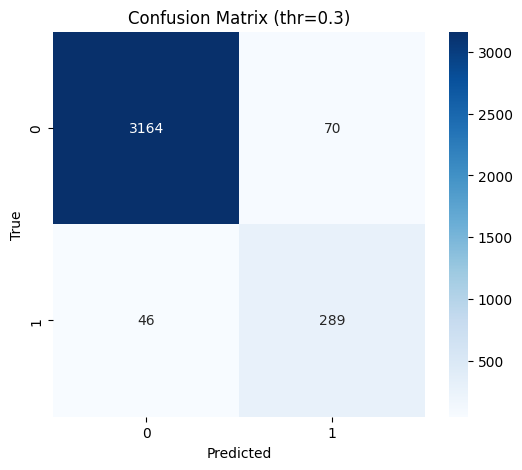

Classification Report
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.98      3234
    Abnormal       0.81      0.86      0.83       335

    accuracy                           0.97      3569
   macro avg       0.90      0.92      0.91      3569
weighted avg       0.97      0.97      0.97      3569

AUC: 0.9825


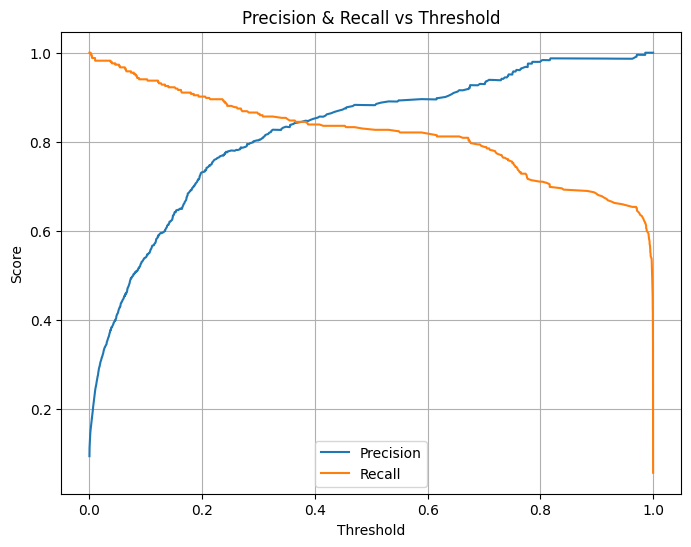

In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_recall_curve
)
import seaborn as sns

# Predict
y_pred_proba = model.predict(X_test)
threshold = 0.3
y_pred = (y_pred_proba >= threshold).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (thr={threshold})")
plt.show()

# Report e AUC
print("Classification Report")
print(classification_report(y_test, y_pred, target_names=['Normal','Abnormal']))
print(f"AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Precision-Recall vs Threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision & Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()



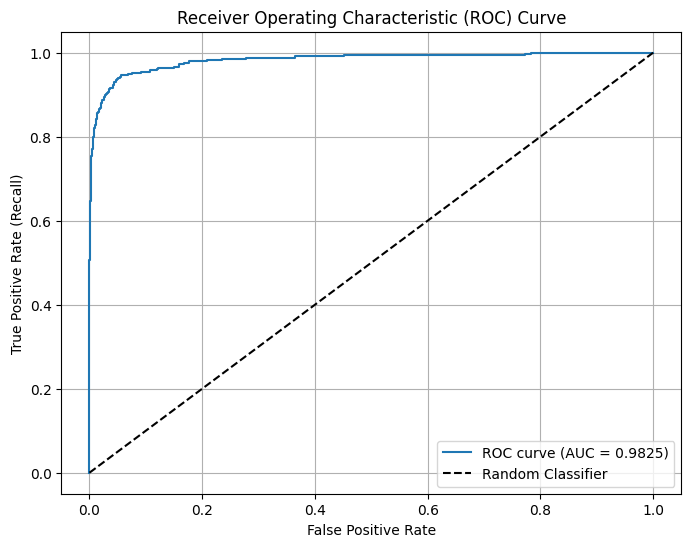

In [ ]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
# prompt: save the model in a .h5 file

model.save('/content/drive/MyDrive/DL_Project/ecg_classification_model.h5')
print("Modello salvato in /content/drive/MyDrive/DL_Project/ecg_classification_model.h5")


Modello salvato in /content/drive/MyDrive/DL_Project/ecg_classification_model.h5


-----------------------------------------------------------------------------------------------------
